In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import cnn
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset
from datetime import datetime
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# For testing

train = list(range(0, 100))
val = list(range(100, 200))

trainset_1 = torch.utils.data.Subset(trainset, train)
trainset_2 = torch.utils.data.Subset(trainset, val)

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=4,
                                            shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=4,
                                            shuffle=True, num_workers=2)

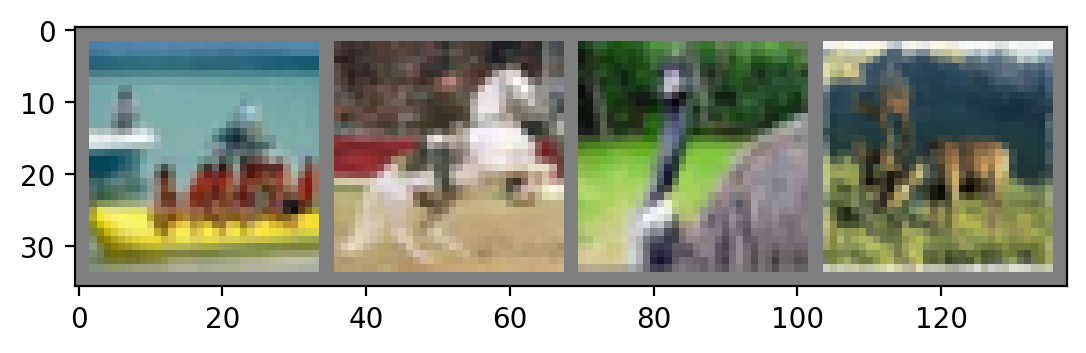

ship  horse bird  deer 


In [14]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, criterion, optimizer, device, log_dir):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.writer = SummaryWriter(log_dir=f"logs/" + log_dir + f"{datetime.now().strftime('%Y%m%d-%H%M%S')}")

    def train(self, epochs):
        for epoch in range(epochs):
            train_loss = 0.0
            train_acc = 0.0
            self.model.train()

            for i, data in enumerate(self.train_dataloader):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_acc += (predicted == labels).sum().item()

            train_loss /= len(self.train_dataloader)
            train_acc /= len(self.train_dataloader)

            self.writer.add_scalar("Loss/train", train_loss, epoch)
            self.writer.add_scalar("Accuracy/train", train_acc, epoch)

            val_loss = 0.0
            val_acc = 0.0
            self.model.eval()

            with torch.no_grad():
                for i, data in enumerate(self.val_dataloader):
                    inputs, labels = data
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_acc += (predicted == labels).sum().item()

            val_loss /= len(self.val_dataloader)
            val_acc /= len(self.val_dataloader.dataset)
            self.writer.add_scalar("Loss/val", val_loss, epoch)
            self.writer.add_scalar("Accuracy/val", val_acc, epoch)

            print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}")


In [12]:
vgg = cnn.VGG(in_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=vgg.parameters(), momentum=0.9, lr=5e-3)
trainer = Trainer(model=vgg, train_dataloader=trainloader_1, val_dataloader=trainloader_2, criterion=criterion, optimizer=optimizer, device=torch.device('cpu'), log_dir="check_overfits_small_train/")

In [13]:
trainer.train(epochs=20)

Epoch 1/20: Train Loss = 2.3030, Train Accuracy = 0.1600, Val Loss = 2.3023, Val Accuracy = 0.1100
Epoch 2/20: Train Loss = 2.3028, Train Accuracy = 0.1600, Val Loss = 2.3023, Val Accuracy = 0.1100
Epoch 3/20: Train Loss = 2.3026, Train Accuracy = 0.1600, Val Loss = 2.3023, Val Accuracy = 0.1100
Epoch 4/20: Train Loss = 2.3024, Train Accuracy = 0.5600, Val Loss = 2.3023, Val Accuracy = 0.1200
Epoch 5/20: Train Loss = 2.3022, Train Accuracy = 0.6400, Val Loss = 2.3023, Val Accuracy = 0.1200
Epoch 6/20: Train Loss = 2.3020, Train Accuracy = 0.6400, Val Loss = 2.3023, Val Accuracy = 0.1200
Epoch 7/20: Train Loss = 2.3018, Train Accuracy = 0.6400, Val Loss = 2.3023, Val Accuracy = 0.1200
Epoch 8/20: Train Loss = 2.3016, Train Accuracy = 0.6400, Val Loss = 2.3024, Val Accuracy = 0.1200
Epoch 9/20: Train Loss = 2.3014, Train Accuracy = 0.6400, Val Loss = 2.3023, Val Accuracy = 0.1200
Epoch 10/20: Train Loss = 2.3012, Train Accuracy = 0.6400, Val Loss = 2.3024, Val Accuracy = 0.1200
Epoch 11/

In [21]:
vgg = cnn.VGG(in_channels=3)


c:\Users\frede\OneDrive\Documents\KTH_2022_2023\DD2424_DL_in_DS\Project\Cifar-10-CNN\cifar-10-cnn\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([4, 10])